<div style="
    background: linear-gradient(135deg, #f1fdf7, #dcfce7);
    color: #14532d;
    padding: 28px 32px;
    border-radius: 14px;
    box-shadow: 0 8px 18px rgba(0,0,0,0.10);
">
    <h1 style="margin:0;">📦 Classification Automatique de Produits E-commerce</h1>
    <h3 style="margin-top:8px; font-weight:normal;">
        NOTEBOOK 1 — Exploration et Analyse des Données (EDA)
    </h3>
    <p><b>Dataset :</b> flipkart_com-ecommerce_sample_1050.csv</p>
    <p><b>Objectif :</b> Explorer, visualiser et comprendre le dataset avant le preprocessing</p>
    <p><b>Date :</b> Janvier 2026</p>
</div>

### IMPORTS ET CONFIGURATION

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import json
import re
import os
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Couleurs personnalisées pour les graphiques
COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', 
          '#F7DC6F', '#BB8FCE', '#85C1E2', '#F8B739', '#52B788',
          '#E63946', '#F1FAEE', '#A8DADC', '#457B9D', '#1D3557']

print("✅ Bibliothèques importées avec succès !")
print("="*80)

✅ Bibliothèques importées avec succès !


### CHARGEMENT ET APERÇU INITIAL

In [24]:
# Chemins des données
DATA_PATH = '../Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
IMAGES_PATH = '../Data/Flipkart/Images'

# Chargement le dataset
print(f" Chargement du dataset depuis : {DATA_PATH}\n")

try:
    df = pd.read_csv(DATA_PATH, encoding='utf-8')
    print("Dataset chargé avec succès !")
except Exception as e:
    print(f" Erreur lors du chargement : {e}")
    print("Tentative avec encoding latin-1...")
    df = pd.read_csv(DATA_PATH, encoding='latin-1')
    print(" Dataset chargé avec encoding latin-1 !")

print(f"\n INFORMATIONS GÉNÉRALES :")
print(f"Nombre total de produits : {len(df):,}")
print(f"Nombre de colonnes : {df.shape[1]}")

# Vérification
if os.path.exists(IMAGES_PATH):
    n_images = len([f for f in os.listdir(IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))])
    print(f" Images disponibles : {n_images:,} fichiers dans {IMAGES_PATH}")
else:
    print(f" Le dossier d'images n'existe pas : {IMAGES_PATH}")

print("="*80)

 Chargement du dataset depuis : ../Data/Flipkart/flipkart_com-ecommerce_sample_1050.csv

Dataset chargé avec succès !

 INFORMATIONS GÉNÉRALES :
Nombre total de produits : 1,050
Nombre de colonnes : 15
 Images disponibles : 1,050 fichiers dans ../Data/Flipkart/Images


### EXPLORATION DE LA BASE

#### Analyse des données


 ANALYSE DES VALEURS MANQUANTES

 Valeurs manquantes par colonne :
               Colonne  Nombre_Manquant  Pourcentage_Manquant
                 brand              338                 32.19
          retail_price                1                  0.10
      discounted_price                1                  0.10
product_specifications                1                  0.10



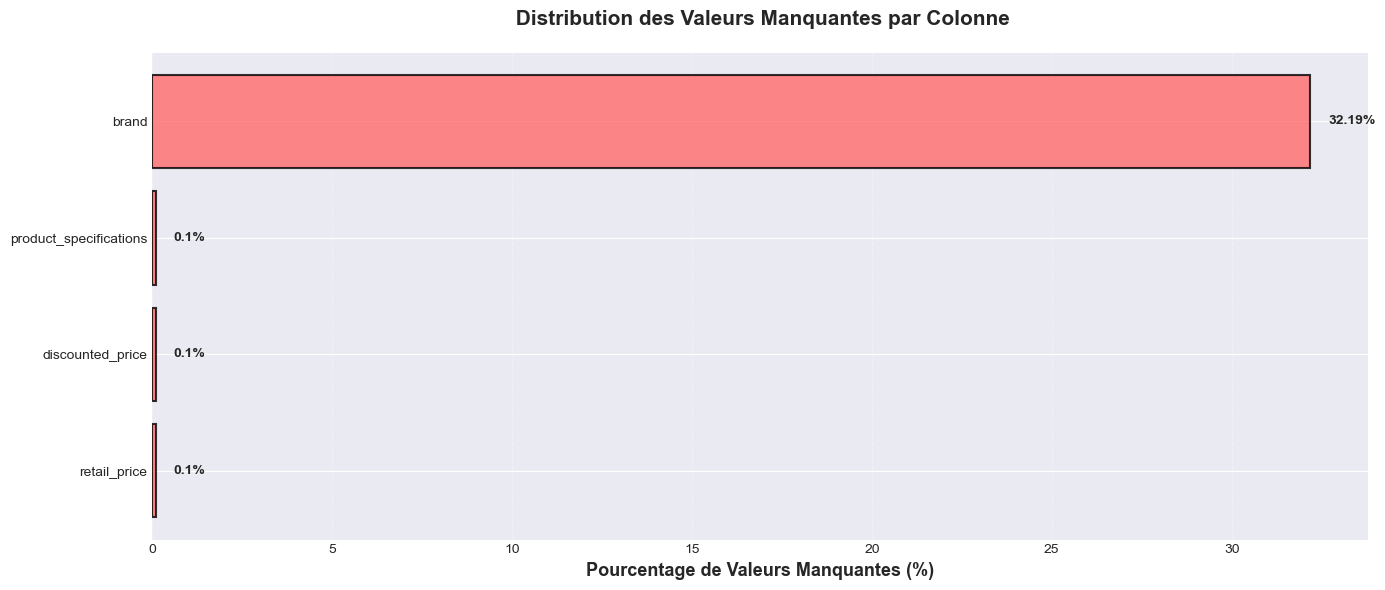

In [25]:
print("\n" + "="*80)
print(" ANALYSE DES VALEURS MANQUANTES")
print("="*80 + "\n")

# Calcul des valeurs manquantes
missing_data = pd.DataFrame({
    'Colonne': df.columns,
    'Nombre_Manquant': df.isnull().sum(),
    'Pourcentage_Manquant': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Nombre_Manquant'] > 0].sort_values(
    'Pourcentage_Manquant', ascending=False
)

if len(missing_data) > 0:
    print(" Valeurs manquantes par colonne :")
    print(missing_data.to_string(index=False))
else:
    print(" Aucune valeur manquante détectée !")

print("\n" + "="*80)

# Visualisation des valeurs manquantes
if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    missing_data_sorted = missing_data.sort_values('Pourcentage_Manquant', ascending=True)
    
    bars = ax.barh(missing_data_sorted['Colonne'], 
                   missing_data_sorted['Pourcentage_Manquant'], 
                   color=COLORS[0], edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Pourcentage de Valeurs Manquantes (%)', fontsize=13, fontweight='bold')
    ax.set_title(' Distribution des Valeurs Manquantes par Colonne', 
                fontsize=15, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Ajout des valeurs sur les barres
    for i, (bar, v) in enumerate(zip(bars, missing_data_sorted['Pourcentage_Manquant'])):
        ax.text(v + 0.5, i, f'{v}%', va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### Analyse des doublons

In [26]:
print("\n ANALYSE DES DOUBLONS :\n")

# Vérification des doublons sur toutes les colonnes
duplicates_all = df.duplicated().sum()
print(f"Nombre de lignes complètement dupliquées : {duplicates_all}")

# Vérification des doublons sur product_name
if 'product_name' in df.columns:
    duplicates_name = df.duplicated(subset=['product_name']).sum()
    print(f"Nombre de produits avec le même nom : {duplicates_name}")

# Vérification des doublons sur pid
if 'pid' in df.columns:
    duplicates_pid = df.duplicated(subset=['pid']).sum()
    print(f"Nombre de PIDs dupliqués : {duplicates_pid}")

print("\n" + "="*80)


 ANALYSE DES DOUBLONS :

Nombre de lignes complètement dupliquées : 0
Nombre de produits avec le même nom : 0
Nombre de PIDs dupliqués : 0



### EXTRACTION ET ANALYSE DE LA VARIABLE CIBLE (CATEGORIE)

In [27]:
print("\n ANALYSE DE LA HIÉRARCHIE DES CATÉGORIES :\n")

def extract_categories(category_tree):
    """
    Extrait les différents niveaux de catégories depuis product_category_tree
    Exemple: "Electronics >> Phones >> Smartphones" -> ['Electronics', 'Phones', 'Smartphones']
    """
    if pd.isna(category_tree):
        return [None, None, None]

    # Nettoyage et extraire
    try:
        # Suppression les crochets et guillemets
        clean = str(category_tree).strip('[]"').replace('"', '')
        # Séparation par >>
        categories = [cat.strip() for cat in clean.split('>>')]
        
        # Jusqu'à 3 niveaux
        level1 = categories[0] if len(categories) > 0 else None
        level2 = categories[1] if len(categories) > 1 else None
        level3 = categories[2] if len(categories) > 2 else None
        
        return [level1, level2, level3]
    except:
        return [None, None, None]

# Extraction des niveaux de catégories
df[['category_level1', 'category_level2', 'category_level3']] = pd.DataFrame(
    df['product_category_tree'].apply(extract_categories).tolist(), 
    index=df.index
)

# Affichage des exemples
print("Exemples de hiérarchie de catégories :")
print(df[['product_name', 'category_level1', 'category_level2', 'category_level3']].head(10))
print("\n" + "="*80)

# Statistiques par niveau
for level in [1, 2, 3]:
    col_name = f'category_level{level}'
    n_categories = df[col_name].nunique()
    print(f"\nNiveau {level} : {n_categories} catégories uniques")
    if n_categories > 0 and n_categories < 50:
        print(f"Liste : {sorted(df[col_name].dropna().unique())}")


 ANALYSE DE LA HIÉRARCHIE DES CATÉGORIES :

Exemples de hiérarchie de catégories :
                                                       product_name  \
0        Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                        Sathiyas Cotton Bath Towel   
2                               Eurospa Cotton Terry Face Towel Set   
3   SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4             Jaipur Print Cotton Floral King sized Double Bedsheet   
5                Maserati Time R8851116001 Analog Watch  - For Boys   
6               Camerii WM64 Elegance Analog Watch  - For Men, Boys   
7                 T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys   
8                 Alfajr WY16B Youth Digital Watch  - For Men, Boys   
9  TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men   

   category_level1         category_level2              category_level3  
0  Home Furnishing  Curtains & Accessories                  

#### Visualisation des catégories par niveau


 DISTRIBUTION DES CATÉGORIES PRINCIPALES (Niveau 1) :

category_level1
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64



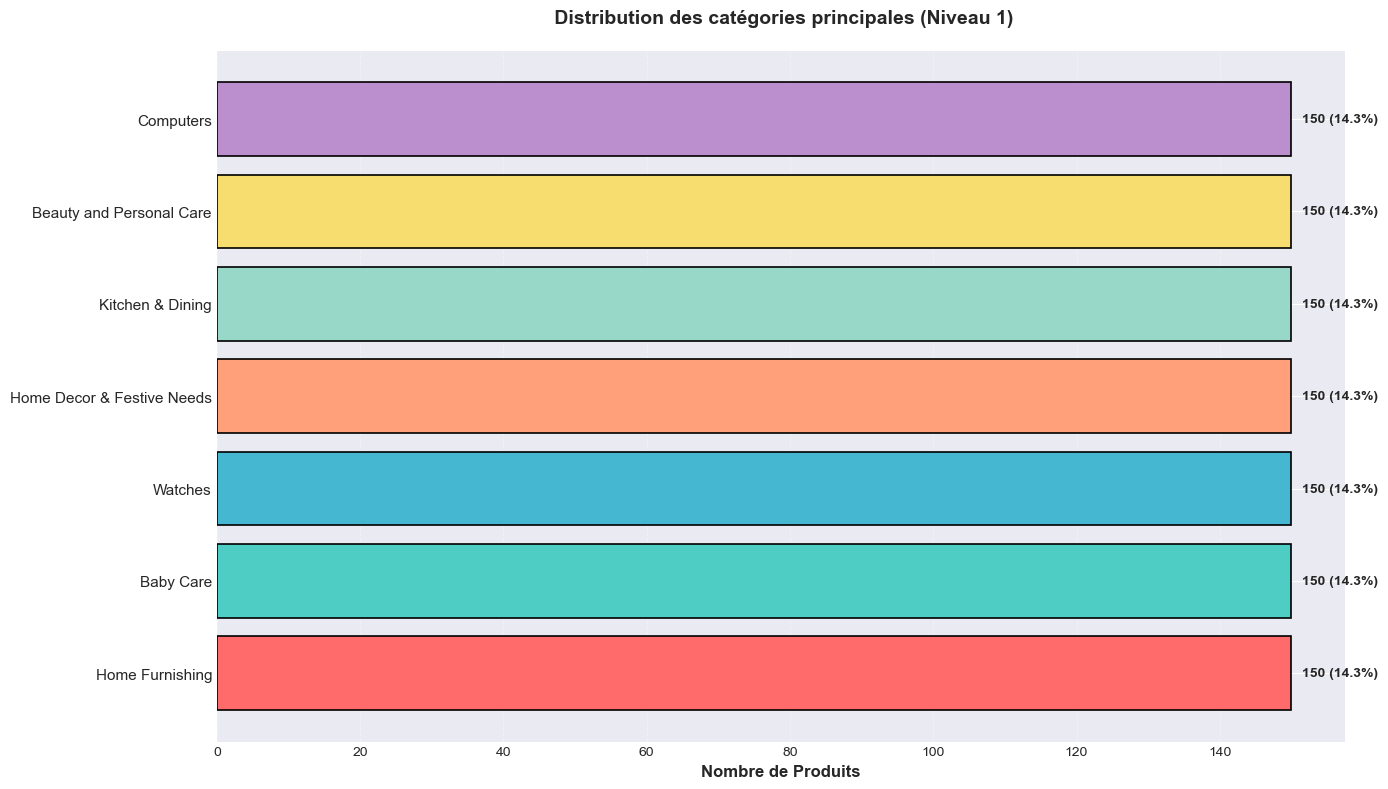

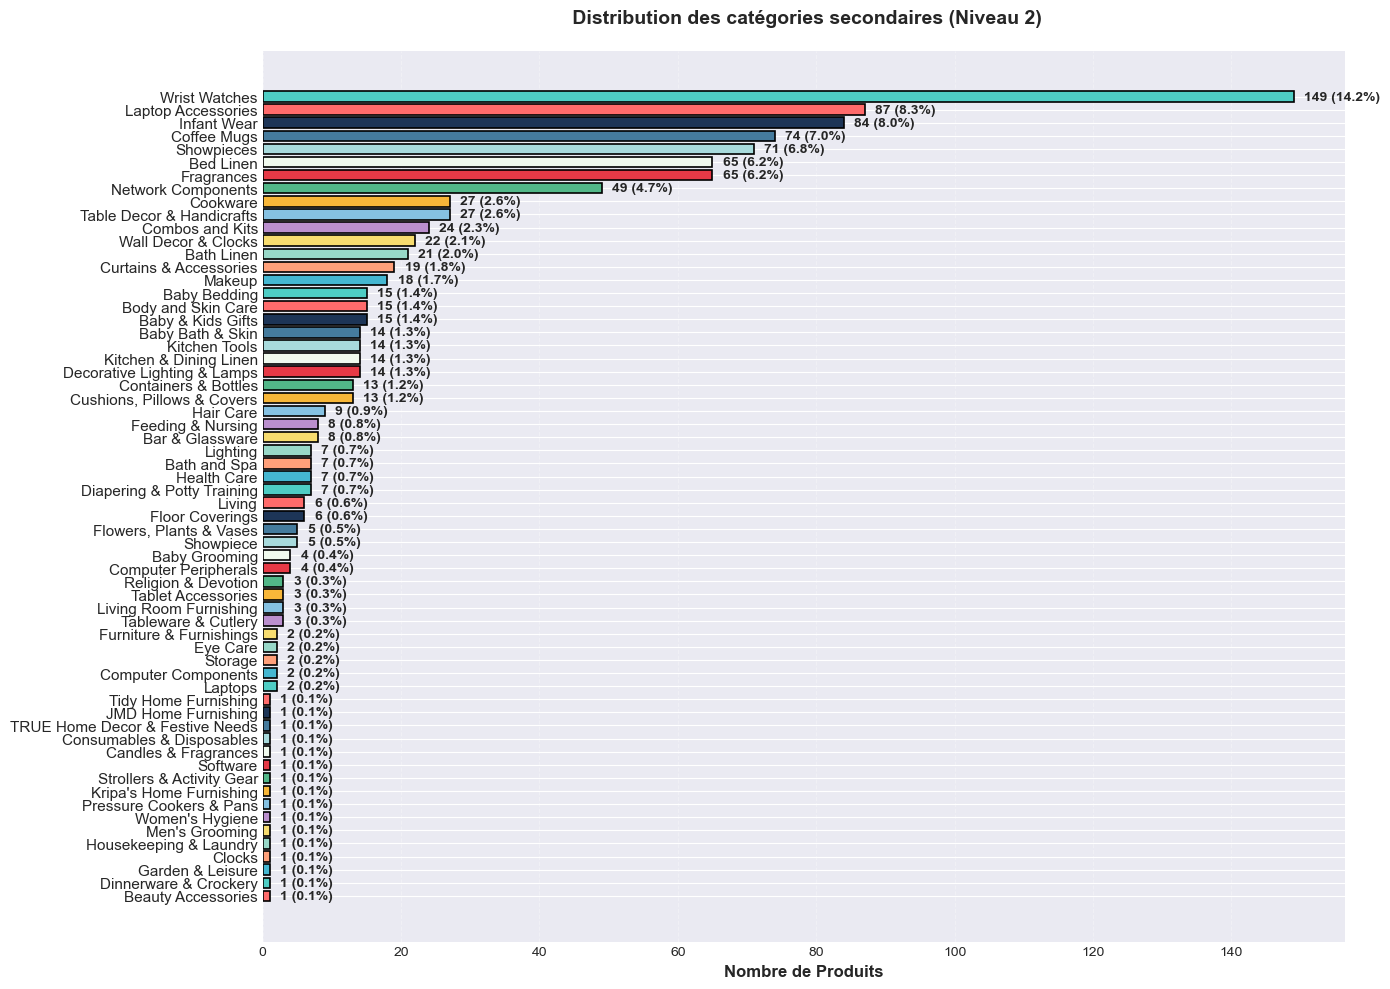

In [28]:
print("\n DISTRIBUTION DES CATÉGORIES PRINCIPALES (Niveau 1) :\n")

# es catégories niveau 1
category_counts_l1 = df['category_level1'].value_counts()
print(category_counts_l1)
print("\n" + "="*80)

# Graphique en barres horizontales
fig, ax = plt.subplots(figsize=(14, 8))
category_counts_l1_sorted = category_counts_l1.sort_values(ascending=True)
bars = ax.barh(range(len(category_counts_l1_sorted)), 
               category_counts_l1_sorted.values,
               color=COLORS[:len(category_counts_l1_sorted)],
               edgecolor='black', linewidth=1.2)

ax.set_yticks(range(len(category_counts_l1_sorted)))
ax.set_yticklabels(category_counts_l1_sorted.index, fontsize=11)
ax.set_xlabel('Nombre de Produits', fontsize=12, fontweight='bold')
ax.set_title(' Distribution des catégories principales (Niveau 1)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Ajout des valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars, category_counts_l1_sorted.values)):
    ax.text(value + max(category_counts_l1_sorted.values)*0.01, i, 
            f'{value} ({value/len(df)*100:.1f}%)', 
            va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Visualisation des catégories niveau 2
category_counts_l2 = df['category_level2'].value_counts()

## Graphique en barres horizontales pour niveau 2
fig, ax = plt.subplots(figsize=(14, 10))
category_counts_l2_sorted = category_counts_l2.sort_values(ascending=True)
bars = ax.barh(range(len(category_counts_l2_sorted)), 
               category_counts_l2_sorted.values,
               color=COLORS[:len(category_counts_l2_sorted)],
               edgecolor='black', linewidth=1.2)        
ax.set_yticks(range(len(category_counts_l2_sorted)))
ax.set_yticklabels(category_counts_l2_sorted.index, fontsize=11)
ax.set_xlabel('Nombre de Produits', fontsize=12, fontweight='bold')
ax.set_title(' Distribution des catégories secondaires (Niveau 2)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')    
# Ajout des valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars, category_counts_l2_sorted.values)):
    ax.text(value + max(category_counts_l2_sorted.values)*0.01, i, 
            f'{value} ({value/len(df)*100:.1f}%)', 
            va='center', fontweight='bold', fontsize=10)    
plt.tight_layout()
plt.show()


##### VISUALISATION EN CAMEMBERT DES TOP CATÉGORIES

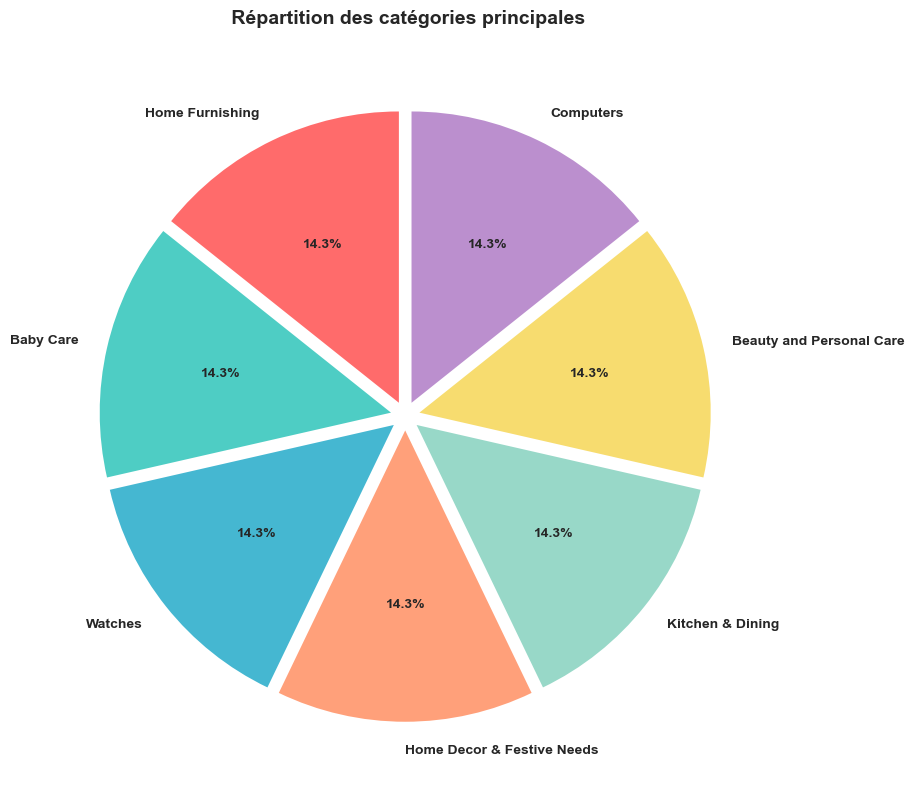

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

# Top 10 catégories + "Autres"
top_n = 10
if len(category_counts_l1) > top_n:
    top_categories = category_counts_l1.head(top_n)
    others_count = category_counts_l1[top_n:].sum()
    plot_data = pd.concat([top_categories, pd.Series({'Autres': others_count})])
else:
    plot_data = category_counts_l1

# le camembert
wedges, texts, autotexts = ax.pie(plot_data.values, 
                                    labels=plot_data.index,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=COLORS,
                                    explode=[0.05]*len(plot_data),
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})

ax.set_title(' Répartition des catégories principales', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### ANALYSE DES TEXTES (product_name et description)

In [30]:
print("\n ANALYSE DES CHAMPS TEXTUELS :\n")

# Fonction pour calculer les statistiques de texte
def text_statistics(text_series, column_name):
    """Calcule les statistiques pour une série de textes"""
    # Suppression des NaN
    texts = text_series.dropna().astype(str)
    
    # Calcul des longueurs
    lengths_chars = texts.str.len()
    lengths_words = texts.str.split().str.len()
    
    stats = {
        'Colonne': column_name,
        'Non-nuls': len(texts),
        'Nuls': text_series.isna().sum(),
        'Longueur_moy_chars': lengths_chars.mean(),
        'Longueur_med_chars': lengths_chars.median(),
        'Longueur_max_chars': lengths_chars.max(),
        'Longueur_min_chars': lengths_chars.min(),
        'Longueur_moy_words': lengths_words.mean(),
        'Longueur_med_words': lengths_words.median(),
        'Longueur_max_words': lengths_words.max(),
        'Longueur_min_words': lengths_words.min(),
    }
    
    return stats, lengths_chars, lengths_words

# Analyse de product_name
if 'product_name' in df.columns:
    stats_name, len_chars_name, len_words_name = text_statistics(df['product_name'], 'product_name')
    print(f"\n{'='*80}")
    print("STATISTIQUES POUR 'product_name' :")
    for key, value in stats_name.items():
        if isinstance(value, float):
            print(f"  {key} : {value:.2f}")
        else:
            print(f"  {key} : {value}")

# Analyse de description
if 'description' in df.columns:
    stats_desc, len_chars_desc, len_words_desc = text_statistics(df['description'], 'description')
    print(f"\n{'='*80}")
    print("STATISTIQUES POUR 'description' :")
    for key, value in stats_desc.items():
        if isinstance(value, float):
            print(f"  {key} : {value:.2f}")
        else:
            print(f"  {key} : {value}")

print("\n" + "="*80)


 ANALYSE DES CHAMPS TEXTUELS :


STATISTIQUES POUR 'product_name' :
  Colonne : product_name
  Non-nuls : 1050
  Nuls : 0
  Longueur_moy_chars : 45.10
  Longueur_med_chars : 43.00
  Longueur_max_chars : 151
  Longueur_min_chars : 8
  Longueur_moy_words : 7.27
  Longueur_med_words : 7.00
  Longueur_max_words : 27
  Longueur_min_words : 2

STATISTIQUES POUR 'description' :
  Colonne : description
  Non-nuls : 1050
  Nuls : 0
  Longueur_moy_chars : 473.82
  Longueur_med_chars : 278.00
  Longueur_max_chars : 3490
  Longueur_min_chars : 109
  Longueur_moy_words : 76.20
  Longueur_med_words : 44.00
  Longueur_max_words : 587
  Longueur_min_words : 13



### VISUALISATION DE LA DISTRIBUTION DES LONGUEURS DE TEXTE

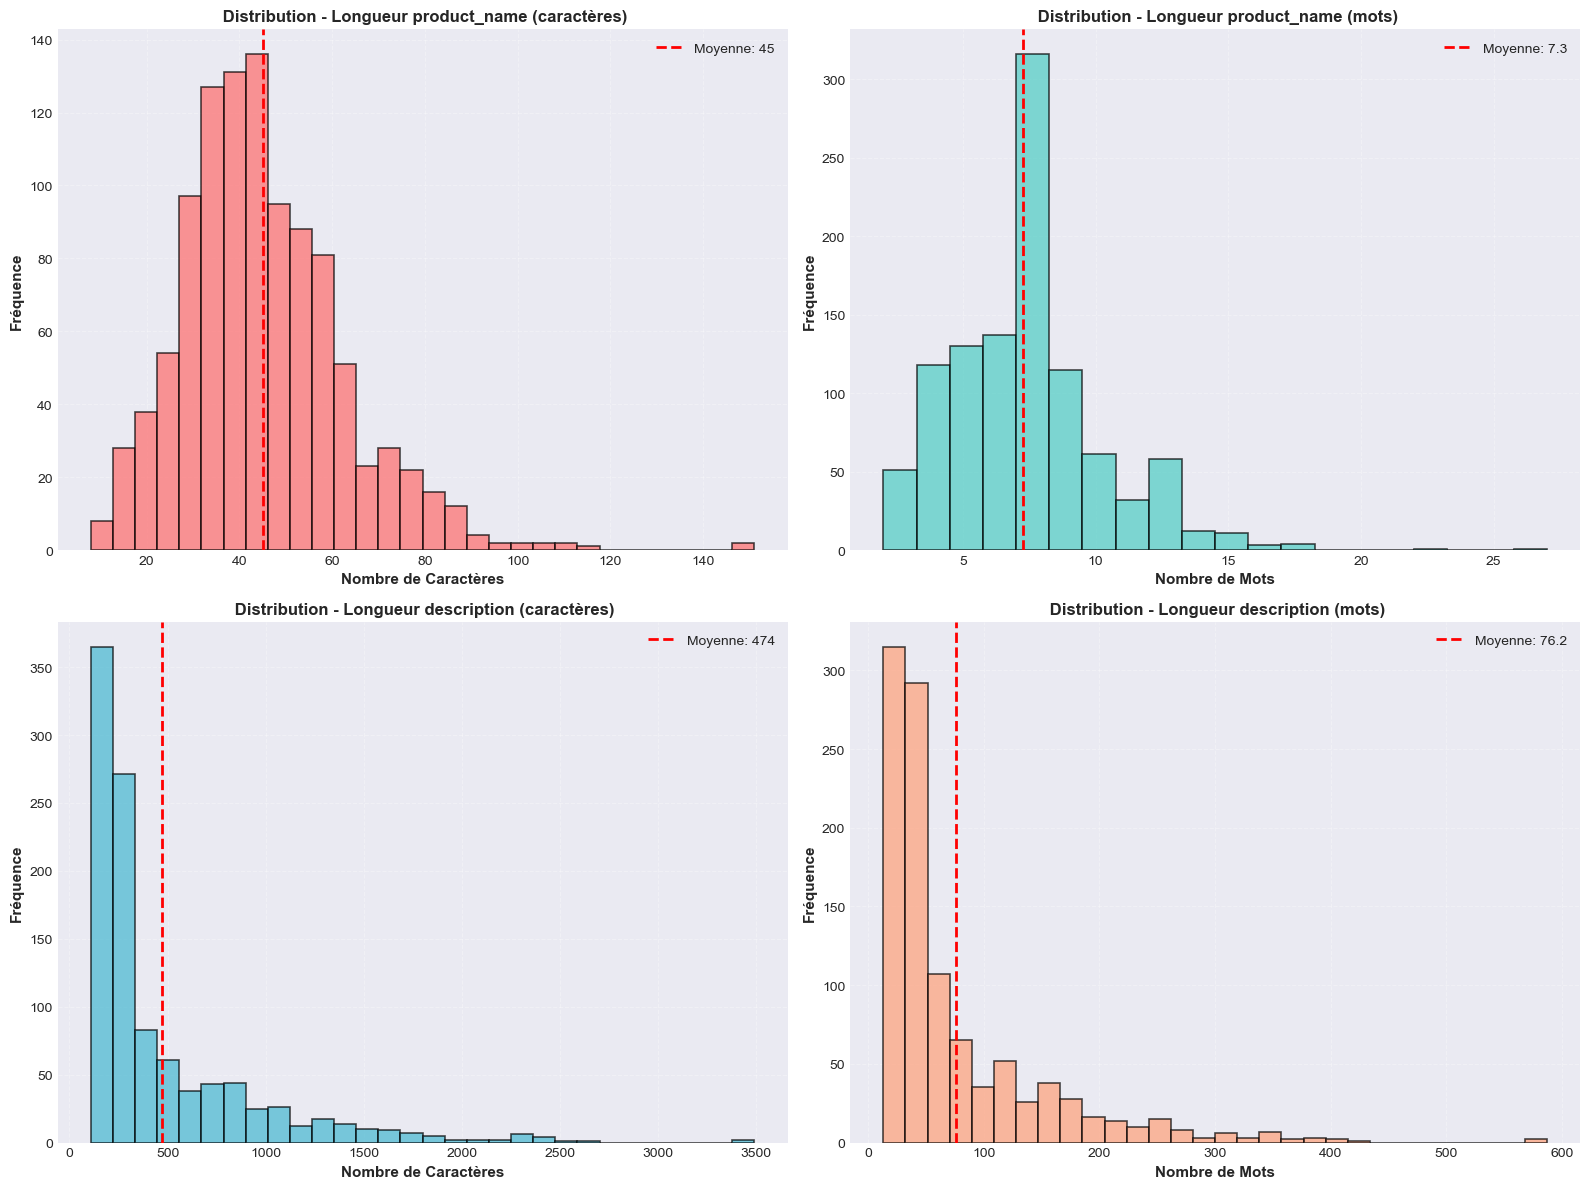

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Product Name - Caractères
if 'product_name' in df.columns:
    axes[0, 0].hist(len_chars_name, bins=30, color=COLORS[0], 
                    edgecolor='black', linewidth=1.2, alpha=0.7)
    axes[0, 0].axvline(len_chars_name.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Moyenne: {len_chars_name.mean():.0f}')
    axes[0, 0].set_xlabel('Nombre de Caractères', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[0, 0].set_title(' Distribution - Longueur product_name (caractères)', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3, linestyle='--')

    # Product Name - Mots
    axes[0, 1].hist(len_words_name, bins=20, color=COLORS[1], 
                    edgecolor='black', linewidth=1.2, alpha=0.7)
    axes[0, 1].axvline(len_words_name.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Moyenne: {len_words_name.mean():.1f}')
    axes[0, 1].set_xlabel('Nombre de Mots', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[0, 1].set_title(' Distribution - Longueur product_name (mots)', 
                         fontsize=12, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, linestyle='--')

# Description - Caractères
if 'description' in df.columns:
    axes[1, 0].hist(len_chars_desc, bins=30, color=COLORS[2], 
                    edgecolor='black', linewidth=1.2, alpha=0.7)
    axes[1, 0].axvline(len_chars_desc.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Moyenne: {len_chars_desc.mean():.0f}')
    axes[1, 0].set_xlabel('Nombre de Caractères', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[1, 0].set_title(' Distribution - Longueur description (caractères)', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3, linestyle='--')

    # Description - Mots
    axes[1, 1].hist(len_words_desc, bins=30, color=COLORS[3], 
                    edgecolor='black', linewidth=1.2, alpha=0.7)
    axes[1, 1].axvline(len_words_desc.mean(), color='red', linestyle='--', 
                       linewidth=2, label=f'Moyenne: {len_words_desc.mean():.1f}')
    axes[1, 1].set_xlabel('Nombre de Mots', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[1, 1].set_title(' Distribution - Longueur description (mots)', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

#### ANALYSE DES MARQUES (brand)


 ANALYSE DES MARQUES :

Nombre total de marques : 490

Top 20 des marques les plus représentées :
brand
PRINT SHAPES      11
Lapguard          11
Lal Haveli        10
Raymond            8
Aroma Comfort      8
Tenda              7
Smartpro           7
Wallmantra         7
Asus               6
Home Originals     6
HP                 6
TRENDnet           5
Rega IT            5
Exotic India       5
Edimax             5
AKUP               5
Sapatos            5
FS Mini Klub       5
Cotonex            4
TP-LINK            4
Name: count, dtype: int64



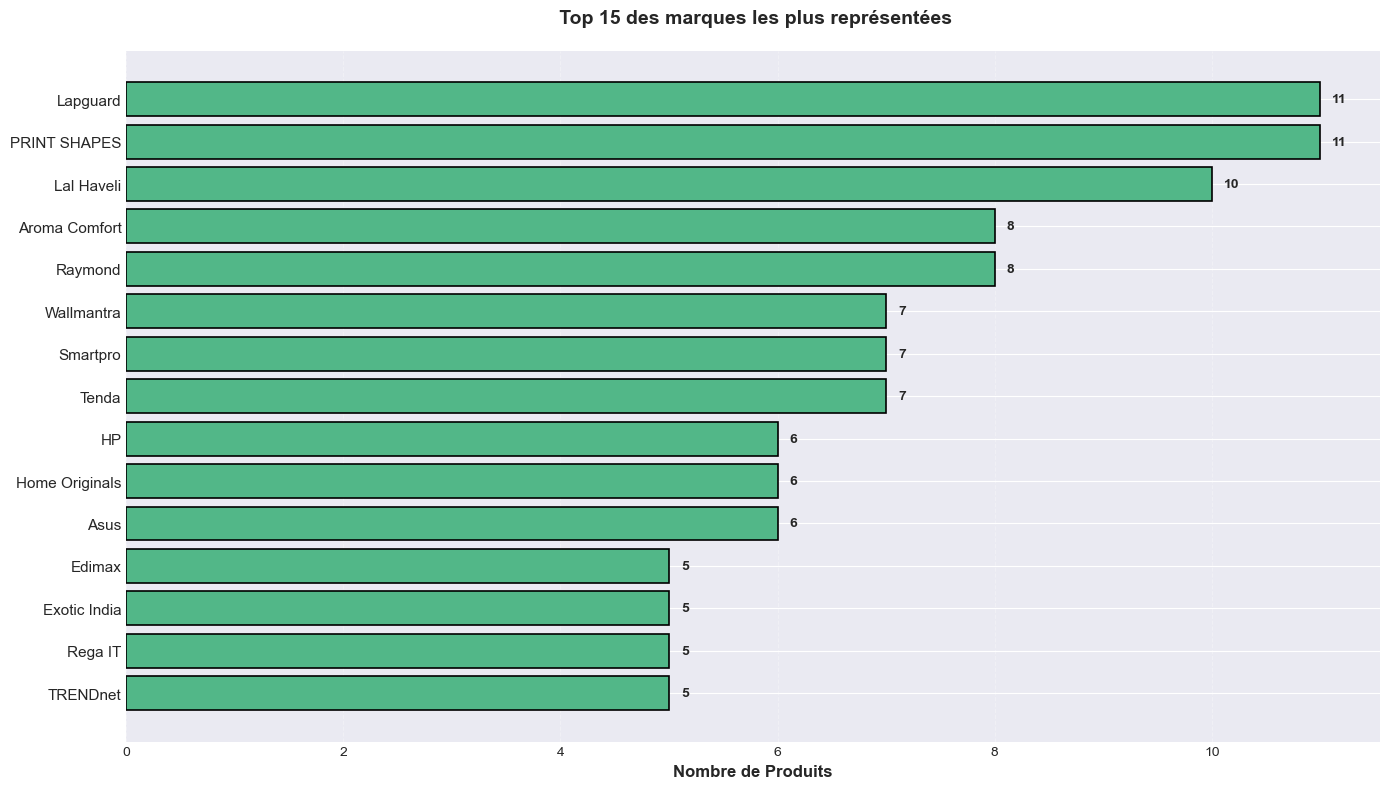

In [32]:
print("\n ANALYSE DES MARQUES :\n")

if 'brand' in df.columns:
    brand_counts = df['brand'].value_counts()
    n_brands = df['brand'].nunique()
    print(f"Nombre total de marques : {n_brands}")
    print(f"\nTop 20 des marques les plus représentées :")
    print(brand_counts.head(20))
    print("\n" + "="*80)
    
    # Visualisation Top 15
    fig, ax = plt.subplots(figsize=(14, 8))
    top_brands = brand_counts.head(15).sort_values(ascending=True)
    bars = ax.barh(range(len(top_brands)), top_brands.values,
                   color=COLORS[9], edgecolor='black', linewidth=1.2)
    
    ax.set_yticks(range(len(top_brands)))
    ax.set_yticklabels(top_brands.index, fontsize=11)
    ax.set_xlabel('Nombre de Produits', fontsize=12, fontweight='bold')
    ax.set_title(' Top 15 des marques les plus représentées', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, value) in enumerate(zip(bars, top_brands.values)):
        ax.text(value + max(top_brands.values)*0.01, i, 
                f'{value}', va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### ANALYSE DES PRIX (retail_price et discounted_price)


 ANALYSE DES PRIX :

PRIX DE DÉTAIL (retail_price) :
count      1049.000000
mean       2186.197331
std        7639.229411
min          35.000000
25%         555.000000
50%         999.000000
75%        1999.000000
max      201000.000000
Name: retail_price_clean, dtype: float64

PRIX RÉDUIT (discounted_price) :
count      1049.000000
mean       1584.527169
std        7475.099680
min          35.000000
25%         340.000000
50%         600.000000
75%        1199.000000
max      201000.000000
Name: discounted_price_clean, dtype: float64

TAUX DE REMISE (%) :
count    1049.000000
mean       32.620897
std        24.366879
min         0.000000
25%         9.090909
50%        33.366667
75%        53.887606
max        91.952663
Name: discount_rate, dtype: float64



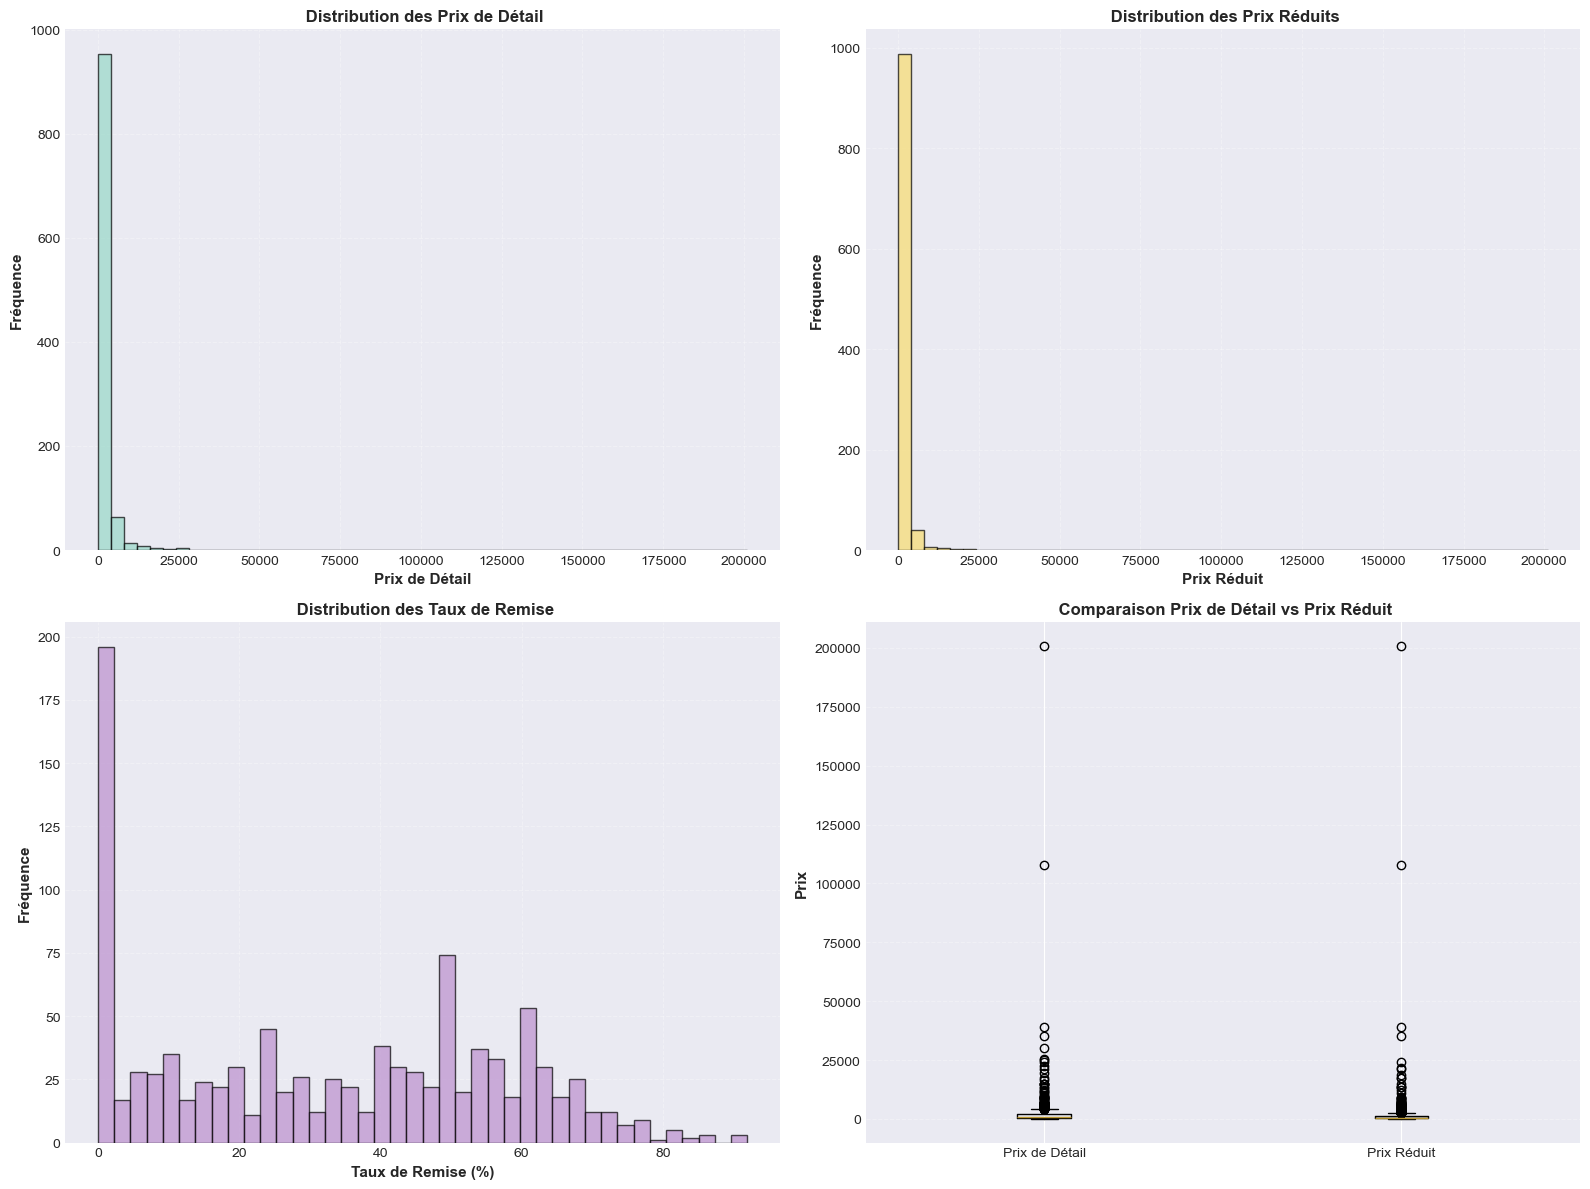

In [33]:
print("\n ANALYSE DES PRIX :\n")
## Suppression les lignes avec retail_price manquant
df = df[df['retail_price'].notna()]
if 'retail_price' in df.columns and 'discounted_price' in df.columns:
    # Nettoyage des prix (supprimer les virgules si présentes)
    df['retail_price_clean'] = pd.to_numeric(
        df['retail_price'].astype(str).str.replace(',', ''), errors='coerce'
    )
    df['discounted_price_clean'] = pd.to_numeric(
        df['discounted_price'].astype(str).str.replace(',', ''), errors='coerce'
    )
    ## Suppression les lignes avec discounted_price manquant
    df = df[df['discounted_price_clean'].notna()]
    # Calcul du taux de remise
    df['discount_rate'] = ((df['retail_price_clean'] - df['discounted_price_clean']) / 
                           df['retail_price_clean'] * 100)
    
    # Statistiques
    print("PRIX DE DÉTAIL (retail_price) :")
    print(df['retail_price_clean'].describe())
    print("\nPRIX RÉDUIT (discounted_price) :")
    print(df['discounted_price_clean'].describe())
    print("\nTAUX DE REMISE (%) :")
    print(df['discount_rate'].describe())
    
    print("\n" + "="*80)
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribution des prix de détail
    axes[0, 0].hist(df['retail_price_clean'].dropna(), bins=50, color=COLORS[4], 
                    edgecolor='black', linewidth=1, alpha=0.7)
    axes[0, 0].set_xlabel('Prix de Détail', fontsize=11, fontweight='bold')
    axes[0, 0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[0, 0].set_title(' Distribution des Prix de Détail', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].grid(alpha=0.3, linestyle='--')
    
    # Distribution des prix réduits
    axes[0, 1].hist(df['discounted_price_clean'].dropna(), bins=50, color=COLORS[5], 
                    edgecolor='black', linewidth=1, alpha=0.7)
    axes[0, 1].set_xlabel('Prix Réduit', fontsize=11, fontweight='bold')
    axes[0, 1].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[0, 1].set_title(' Distribution des Prix Réduits', 
                         fontsize=12, fontweight='bold')
    axes[0, 1].grid(alpha=0.3, linestyle='--')
    
    # Distribution des taux de remise
    axes[1, 0].hist(df['discount_rate'].dropna(), bins=40, color=COLORS[6], 
                    edgecolor='black', linewidth=1, alpha=0.7)
    axes[1, 0].set_xlabel('Taux de Remise (%)', fontsize=11, fontweight='bold')
    axes[1, 0].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[1, 0].set_title(' Distribution des Taux de Remise', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, linestyle='--')
    
    # Boxplot comparatif
    axes[1, 1].boxplot([df['retail_price_clean'].dropna(), 
                        df['discounted_price_clean'].dropna()],
                       labels=['Prix de Détail', 'Prix Réduit'])
    axes[1, 1].set_ylabel('Prix', fontsize=11, fontweight='bold')
    axes[1, 1].set_title(' Comparaison Prix de Détail vs Prix Réduit', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()

### ANALYSE DES NOTES (product_rating et overall_rating)


 ANALYSE DES NOTES :

PRODUCT RATING :
count                    1049
unique                     27
top       No rating available
freq                      888
Name: product_rating, dtype: object
Valeurs uniques : ['1', '1.5', '2', '2.2', '2.3', '2.5', '2.7', '3', '3.1', '3.2', '3.3', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2', '4.3', '4.4', '4.5', '4.7', '4.8', '4.9', '5', 'No rating available']

OVERALL RATING :
count                    1049
unique                     27
top       No rating available
freq                      888
Name: overall_rating, dtype: object
Valeurs uniques : ['1', '1.5', '2', '2.2', '2.3', '2.5', '2.7', '3', '3.1', '3.2', '3.3', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2', '4.3', '4.4', '4.5', '4.7', '4.8', '4.9', '5', 'No rating available']



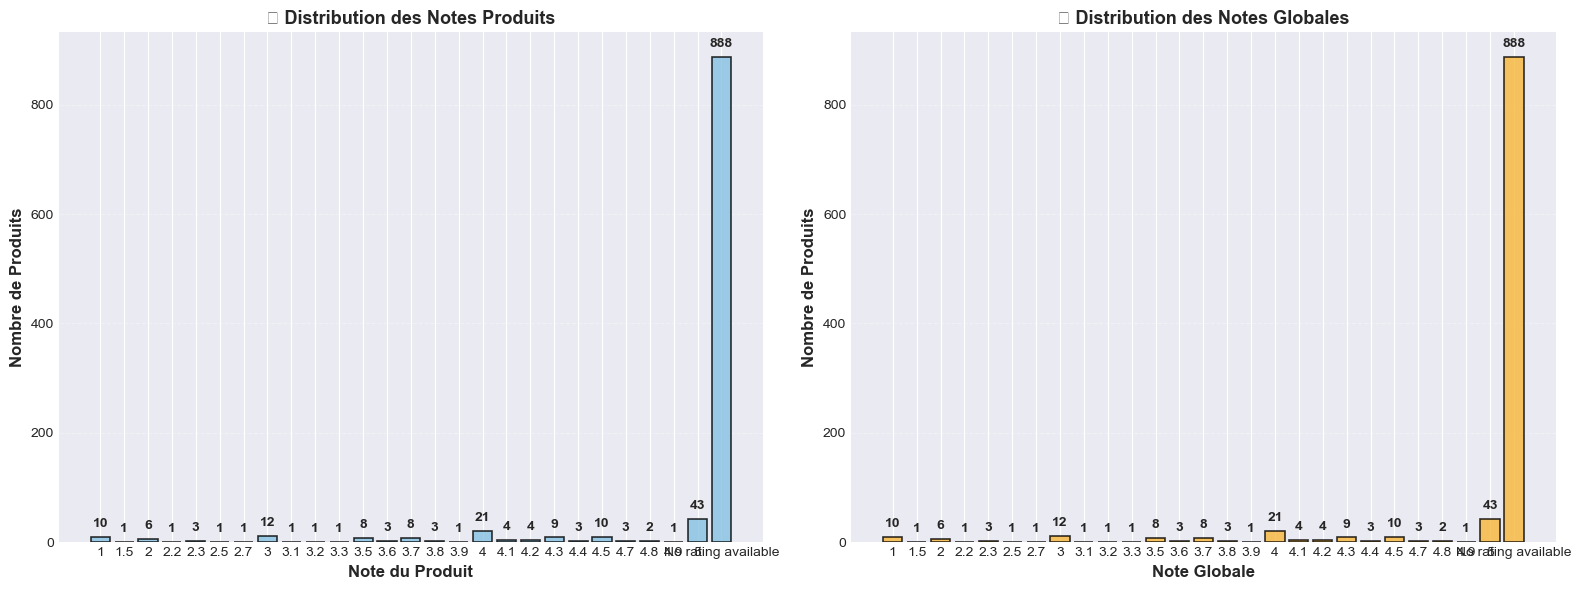

In [34]:
print("\n ANALYSE DES NOTES :\n")

if 'product_rating' in df.columns:
    print("PRODUCT RATING :")
    print(df['product_rating'].describe())
    print(f"Valeurs uniques : {sorted(df['product_rating'].dropna().unique())}")

if 'overall_rating' in df.columns:
    print("\nOVERALL RATING :")
    print(df['overall_rating'].describe())
    print(f"Valeurs uniques : {sorted(df['overall_rating'].dropna().unique())}")

print("\n" + "="*80)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if 'product_rating' in df.columns:
    rating_counts = df['product_rating'].value_counts().sort_index()
    axes[0].bar(rating_counts.index, rating_counts.values, color=COLORS[7], 
                edgecolor='black', linewidth=1.2, alpha=0.8)
    axes[0].set_xlabel('Note du Produit', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Nombre de Produits', fontsize=12, fontweight='bold')
    axes[0].set_title('⭐ Distribution des Notes Produits', 
                      fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(rating_counts.values):
        axes[0].text(rating_counts.index[i], v + max(rating_counts.values)*0.02, 
                     str(v), ha='center', fontweight='bold')

if 'overall_rating' in df.columns:
    overall_counts = df['overall_rating'].value_counts().sort_index()
    axes[1].bar(overall_counts.index, overall_counts.values, color=COLORS[8], 
                edgecolor='black', linewidth=1.2, alpha=0.8)
    axes[1].set_xlabel('Note Globale', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Nombre de Produits', fontsize=12, fontweight='bold')
    axes[1].set_title('⭐ Distribution des Notes Globales', 
                      fontsize=13, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3, linestyle='--')
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(overall_counts.values):
        axes[1].text(overall_counts.index[i], v + max(overall_counts.values)*0.02, 
                     str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### MATRICE DE CORRÉLATION (Variables Numériques)




 ANALYSE DE CORRÉLATION :

Colonnes numériques analysées : ['retail_price', 'discounted_price', 'retail_price_clean', 'discounted_price_clean', 'discount_rate']


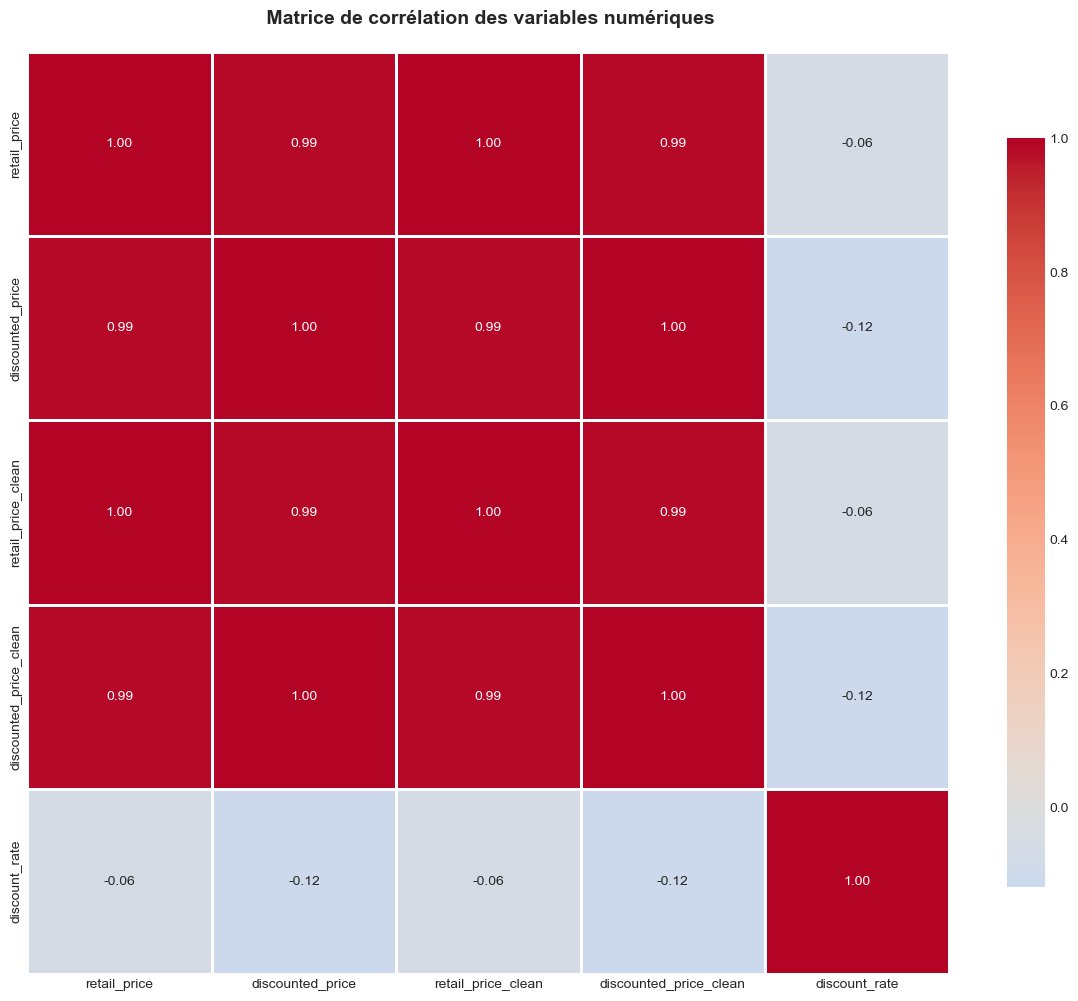

In [35]:
print("\n ANALYSE DE CORRÉLATION :\n")

# Sélection des colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Colonnes numériques analysées : {numeric_cols}")

if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                ax=ax)
    ax.set_title(' Matrice de corrélation des variables numériques', 
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)

#### ANALYSE CROISÉE : CATÉGORIES vs PRIX


 ANALYSE CROISÉE : CATÉGORIES VS PRIX :

Prix par catégorie (top 10) :
                                   mean  median    min       max  count
category_level1                                                        
Watches                     3108.553333   780.0  150.0  201000.0    150
Computers                   2446.193333  1378.5   88.0   38890.0    150
Home Decor & Festive Needs  2108.653333   899.5  111.0   21800.0    150
Home Furnishing             1271.140000   899.0  138.0    8999.0    150
Baby Care                    857.610738   549.0   70.0    9375.0    149
Beauty and Personal Care     828.240000   370.0   85.0   18799.0    150
Kitchen & Dining             466.453333   299.0   35.0    2999.0    150



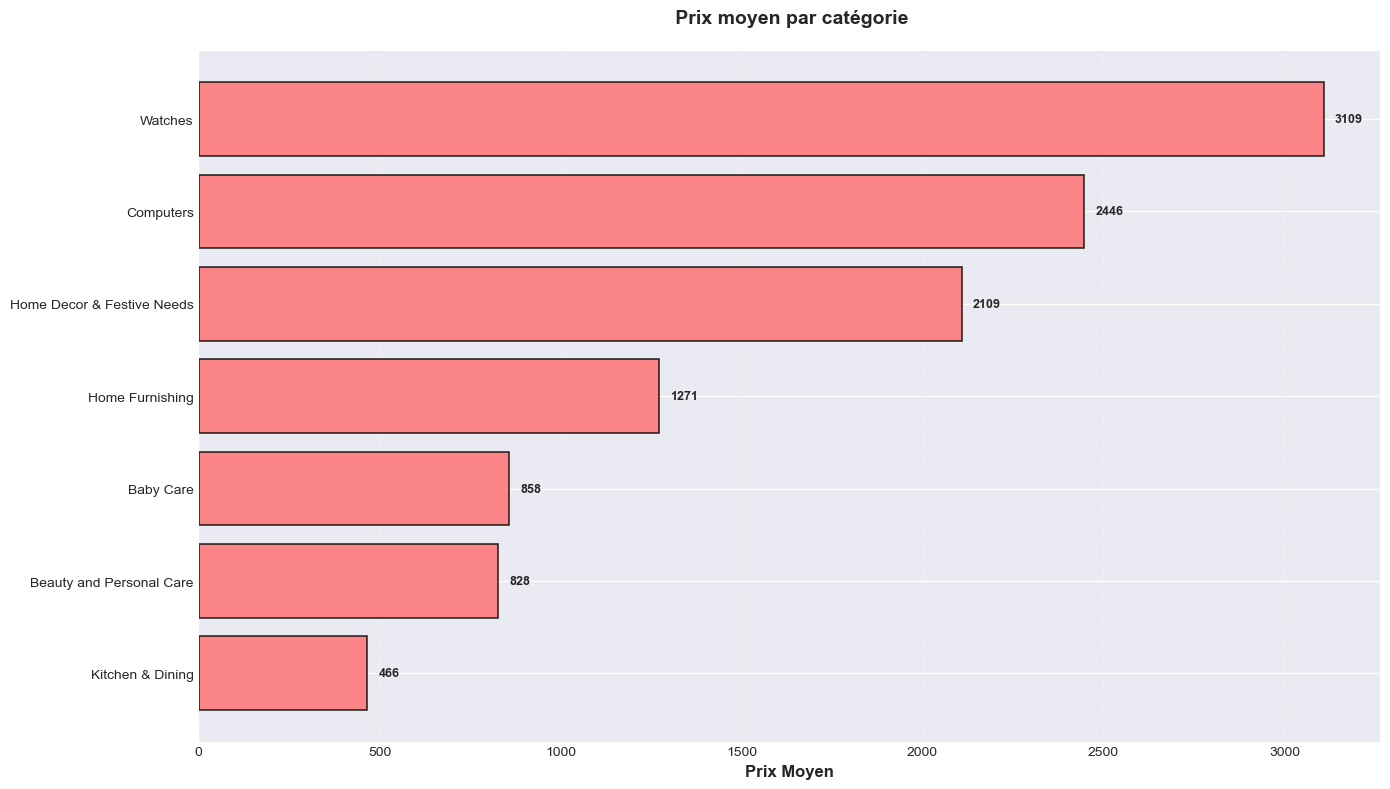

In [36]:
print("\n ANALYSE CROISÉE : CATÉGORIES VS PRIX :\n")

if 'category_level1' in df.columns and 'discounted_price_clean' in df.columns:
    # Prix moyen par catégorie
    price_by_category = df.groupby('category_level1')['discounted_price_clean'].agg([
        'mean', 'median', 'min', 'max', 'count'
    ]).sort_values('mean', ascending=False)
    
    print("Prix par catégorie (top 10) :")
    print(price_by_category.head(10))
    print("\n" + "="*80)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(14, 8))
    top_categories = price_by_category.head(15).sort_values('mean', ascending=True)
    bars = ax.barh(range(len(top_categories)), top_categories['mean'],
                   color=COLORS[0], edgecolor='black', linewidth=1.2, alpha=0.8)
    
    ax.set_yticks(range(len(top_categories)))
    ax.set_yticklabels(top_categories.index, fontsize=10)
    ax.set_xlabel('Prix Moyen', fontsize=12, fontweight='bold')
    ax.set_title(' Prix moyen par catégorie', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, value) in enumerate(zip(bars, top_categories['mean'])):
        ax.text(value + max(top_categories['mean'])*0.01, i, 
                f'{value:.0f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

### WORDCLOUD DES NOMS DE PRODUITS (PAR CATÉGORIE)


 WORDCLOUDS PAR CATÉGORIE :



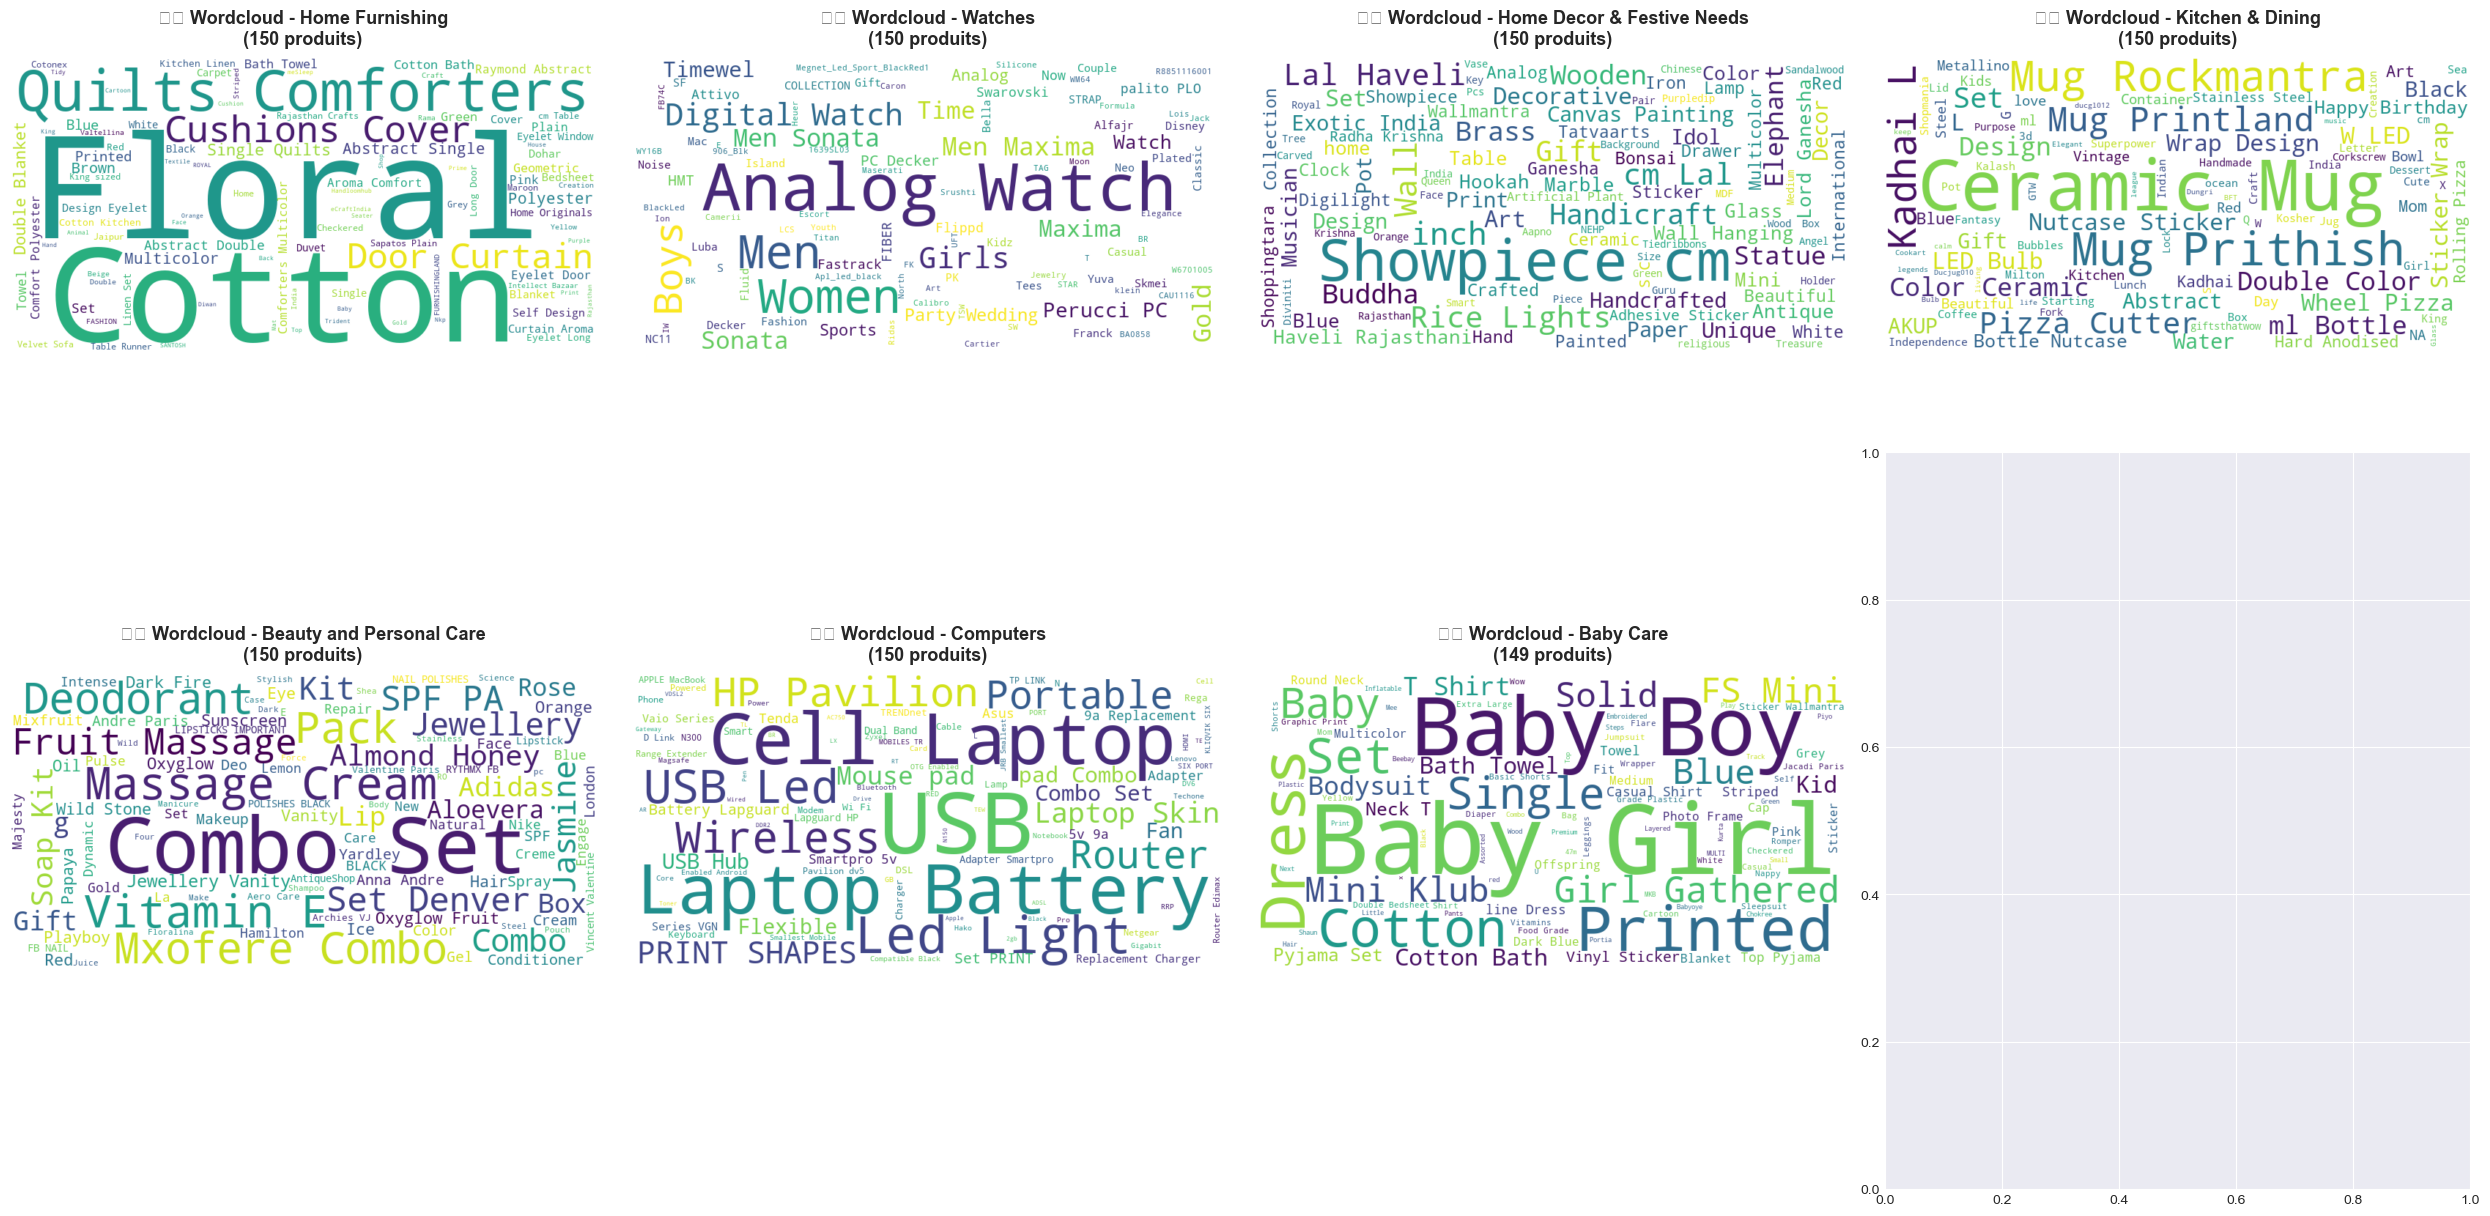

In [37]:
print("\n WORDCLOUDS PAR CATÉGORIE :\n")

try:
    from wordcloud import WordCloud
    
    if 'product_name' in df.columns and 'category_level1' in df.columns:
        # Sélection des 7 catégories (Niveau 1)
        top_7_categories = df['category_level1'].value_counts().head(7).index
        
        fig, axes = plt.subplots(2, 4, figsize=(25, 14))
        axes = axes.ravel()
        
        for idx, category in enumerate(top_7_categories):
            # Filtre des produits de cette catégorie
            category_products = df[df['category_level1'] == category]['product_name'].dropna()
            
            # Création du texte combiné
            text = ' '.join(category_products.astype(str).values)
            
            # Génération du wordcloud
            wordcloud = WordCloud(width=800, height=400, 
                                  background_color='white',
                                  colormap='viridis',
                                  max_words=100,
                                  relative_scaling=0.5).generate(text)
            
            axes[idx].imshow(wordcloud, interpolation='bilinear')
            axes[idx].axis('off')
            axes[idx].set_title(f'☁️ Wordcloud - {category}\n({len(category_products)} produits)',
                               fontsize=13, fontweight='bold', pad=10)
        
        plt.tight_layout()
        plt.show()
    
except ImportError:
    print(" La bibliothèque 'wordcloud' n'est pas installée.")
    print("Pour l'installer : pip install wordcloud")

### ANALYSE DU BRUIT LEXICAL (RISQUE D'AMBIGUÏTÉ)


 ANALYSE DES AMBIGUITÉS LEXICALES DANS LES CATÉGORIES :

Nombre de termes ambigus trouvés : 329

Exemples de termes ambigus et leurs catégories associées :
  'home': ['Baby Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing']
  'elegance': ['Home Furnishing', 'Watches']
  'red': ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']
  'plain': ['Baby Care', 'Home Furnishing']
  'of': ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining']
  'cream': ['Beauty and Personal Care', 'Home Furnishing']
  'crafts': ['Home Decor & Festive Needs', 'Home Furnishing']
  'creation': ['Home Furnishing', 'Kitchen & Dining']
  'kitchen': ['Home Furnishing', 'Kitchen & Dining']
  'aroma': ['Baby Care', 'Beauty and Personal Care', 'Home Furnishing']


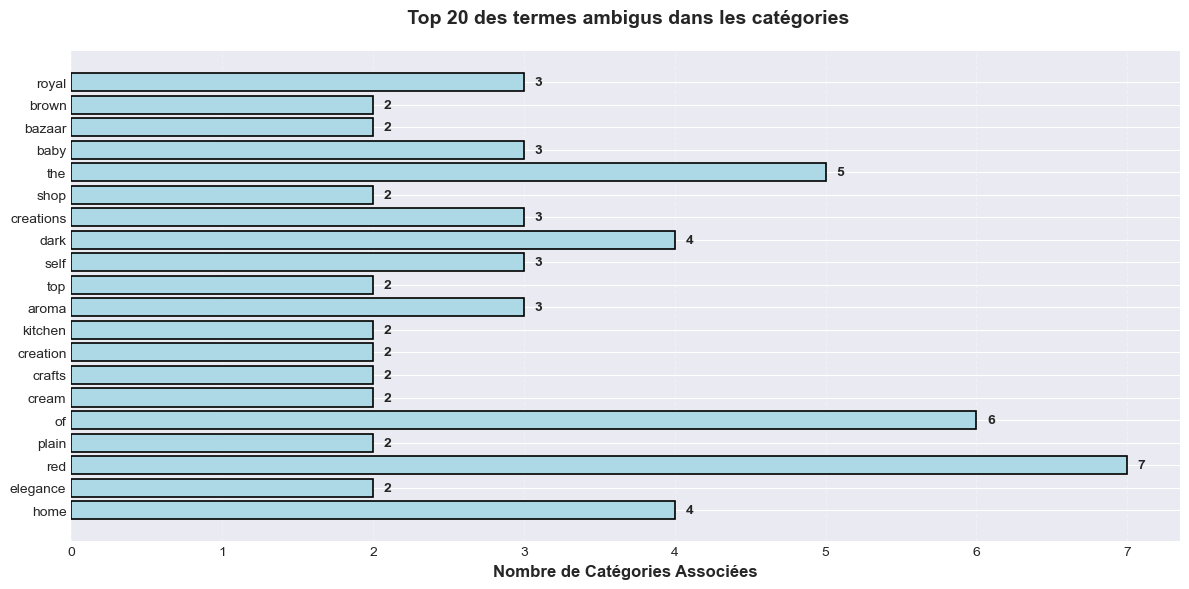

In [38]:

## Analyse des ambiguités lexicales dans les catégories
print("\n ANALYSE DES AMBIGUITÉS LEXICALES DANS LES CATÉGORIES :\n")
if 'category_level1' in df.columns:
    category_terms = {}
    
    for category in df['category_level1'].dropna().unique():
        terms = set()
        products_in_cat = df[df['category_level1'] == category]['product_name'].dropna()
        for product in products_in_cat:
            words = re.findall(r'\b\w+\b', product.lower())
            terms.update(words)
        category_terms[category] = terms
    
    # Trouvons les termes ambigus
    term_categories = {}
    for category, terms in category_terms.items():
        for term in terms:
            if term not in term_categories:
                term_categories[term] = set()
            term_categories[term].add(category)
    
    ambiguous_terms = {term: cats for term, cats in term_categories.items() if len(cats) > 1}
    
    print(f"Nombre de termes ambigus trouvés : {len(ambiguous_terms)}")
    print("\nExemples de termes ambigus et leurs catégories associées :")
    for term, cats in list(ambiguous_terms.items())[:10]:
        print(f"  '{term}': {sorted(cats)}")
        
# Visualisation des termes ambigus
if ambiguous_terms:
    terms = list(ambiguous_terms.keys())
    counts = [len(cats) for cats in ambiguous_terms.values()]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(terms[:20], counts[:20], color="lightblue", edgecolor='black', linewidth=1.2)
    ax.set_xlabel('Nombre de Catégories Associées', fontsize=12, fontweight='bold')
    ax.set_title(' Top 20 des termes ambigus dans les catégories', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, value) in enumerate(zip(bars, counts[:20])):
        ax.text(value + max(counts)*0.01, i, str(value), va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()

### SAUVEGARDE DU DATASET 

In [39]:
print("\n" + "="*80)
print(" SAUVEGARDE DU DATASET ENRICHI")
print("="*80 + "\n")

# Colonnes ajoutées
new_columns = [col for col in df.columns if col not in pd.read_csv(DATA_PATH, nrows=1).columns]

print(" Colonnes ajoutées lors de l'EDA :")
for col in new_columns:
    print(f"   • {col}")

# Sauvegarde
output_file = '../outputs/flipkart_data_eda.csv'
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n Dataset enrichi sauvegardé dans : {output_file}")
print(f" Taille du fichier : {len(df)} lignes × {len(df.columns)} colonnes")

print("\n" + "="*80)
print(" EXPLORATION DES DONNÉES TERMINÉE AVEC SUCCÈS !")
print("="*80)


 SAUVEGARDE DU DATASET ENRICHI

 Colonnes ajoutées lors de l'EDA :
   • category_level1
   • category_level2
   • category_level3
   • retail_price_clean
   • discounted_price_clean
   • discount_rate

 Dataset enrichi sauvegardé dans : ../outputs/flipkart_data_eda.csv
 Taille du fichier : 1049 lignes × 21 colonnes

 EXPLORATION DES DONNÉES TERMINÉE AVEC SUCCÈS !
